# Task 2: Credit card detection

- Develop a machine learning model designed to detect fraudulent credit card
transactions.

- The process involves preprocessing and normalizing transaction data, addressing class imbalance concerns, and partitioning the dataset into training and testing subsets.

- Train a classification algorithm—like logistic regression or random forests—to
differentiate between fraudulent and legitimate transactions.

- Assess the model's efficacy using metrics such as precision, recall, and F1-score.

- Additionally, explore strategies like oversampling or undersampling to enhance
outcomes and refine the model's performance.

# Credit Card Fraud Detection Dataset

## Overview
This dataset comprises anonymized credit card transactions, each labeled as either fraudulent or genuine. The primary aim is to facilitate the detection of fraudulent credit card transactions to prevent customers from being charged for unauthorized purchases.

## Context
Credit card companies rely on robust fraud detection mechanisms to safeguard customers from fraudulent transactions. Detecting and preventing fraudulent activities is crucial for maintaining trust and security in financial transactions.

## Content
- The dataset contains credit card transactions made by European cardholders in September 2013.
- Transactions span over two days, with a total of 284,807 transactions.
- Among these transactions, there are 492 instances of fraud.
- The dataset exhibits significant class imbalance, with fraudulent transactions accounting for only 0.172% of the total.
- Features include numerical inputs resulting from a Principal Component Analysis (PCA) transformation. However, due to confidentiality constraints, the original features and additional background information are not provided.
- Features V1 to V28 represent principal components obtained through PCA, while 'Time' and 'Amount' are original features.
- The 'Time' feature denotes the elapsed time in seconds between each transaction and the first transaction in the dataset.
- The 'Amount' feature indicates the transaction amount.
- The response variable, 'Class', takes a value of 1 for fraudulent transactions and 0 otherwise.

## Recommendations
- Given the class imbalance, it's advisable to evaluate model performance using metrics such as the Area Under the Precision-Recall Curve (AUPRC).
- Accuracy metrics derived from a confusion matrix may not be meaningful due to the imbalance in class distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install ydata-profiling --quiet
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

Retrieving data from Kaggle API

In [2]:
# Local PC data retrieving
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('mlg-ulb/creditcardfraud', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/creditcard.csv")

In [3]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d mlg-ulb/creditcardfraud #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("creditcard.csv") #reading data as pandas dataframe

Separating the dataframe into the slices I will use to analyze the data and undertand it

In [4]:
data_3_principal = df[['Time', 'Amount', 'Class']]
fraudulent_transactions = df[df['Class'] == 1]
not_fraudulent_transactions = df[df['Class'] == 0]

Profile report of the dataset, overview and relationships between Time, Amount and Class variables

In [5]:
pf_3_variables = ProfileReport(data_3_principal)
pf_3_variables

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
pf_fraudulent_trans = ProfileReport(fraudulent_transactions[['Time', 'Amount']])
pf_fraudulent_trans

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA, (Exploratory data analysis)

In [7]:
print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

inf_values = np.isinf(df)
inf_rows, inf_cols = np.where(inf_values)

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')

Total of null data: 0
Total of duplicated data: 1081
Rows with inf values: 0
Columns with inf values: 0


In [8]:
print(f'Data information: \n{df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
print(f'Data description: \n{df.describe()}')

Data description: 
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.

In [10]:
percentage_data_by_class = df['Class'].value_counts(normalize=True)
print(f'Percentage of data by class: \n{percentage_data_by_class}')

Percentage of data by class: 
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [11]:
# Full distribution analysis
from scipy import stats
def calculate_stats(data: pd.DataFrame) -> list:
    """
    Calculate the mean, standard deviation, skewness, and kurtosis for each column in a DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame for which to calculate statistics.

    Returns:
    mean (list): The mean of each column.
    std (list): The standard deviation of each column.
    skewness (list): The skewness of each column.
    kurtosis (list): The kurtosis of each column.
    """
    
    # Initialize lists to store results
    mean, std, skewness, kurtosis = [], [], [], []
    
    for column in data.columns:
        mean.append(data[column].mean())
        std.append(data[column].std())
        skewness.append(stats.skew(data[column]))
        kurtosis.append(stats.kurtosis(data[column]))
    
    # Return the calculated statistics
    return mean, std, skewness, kurtosis


#Usage of the function in the original data
mean, std, skewness, kurtosis = calculate_stats(df)

stats_data = pd.DataFrame({'Column': df.columns, 
                         'Mean': mean,
                         'Std': std,
                         'Skewness': skewness, 
                         'Kurtosis': kurtosis})
stats_data

,Column,Mean,Std,Skewness,Kurtosis
0,Time,9.481386e+04,47488.145955,-0.035567,-1.293528
1,V1,1.168375e-15,1.958696,-3.280650,32.486088
2,V2,3.416908e-16,1.651309,-4.624841,95.771404
3,V3,-1.379537e-15,1.516255,-2.240144,26.619062
4,V4,2.074095e-15,1.415869,0.676289,2.635388
5,V5,9.604066e-16,1.380247,-2.425889,206.900907
6,V6,1.487313e-15,1.332271,1.826571,42.641724
7,V7,-5.556467e-16,1.237094,2.553894,405.600275
8,V8,1.213481e-16,1.194353,-8.521899,220.583080
9,V9,-2.406331e-15,1.098632,0.554677,3.731224


There are not correlations between variables grater or equal than 0.7, but there is one grater or equal than 0.5, which is between `Amount` and `V2`



In [12]:
corr = df.corr()

# Filtering correlations
high_corr_variables = set()
correlation_value = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= correlation_value:
            high_corr_variables.add(corr.columns[i])
            high_corr_variables.add(corr.columns[j])

print(f"Variables with a correlation greater than {correlation_value}:")
print(high_corr_variables)

Variables with a correlation greater than 0.5:
{'Amount', 'V2'}


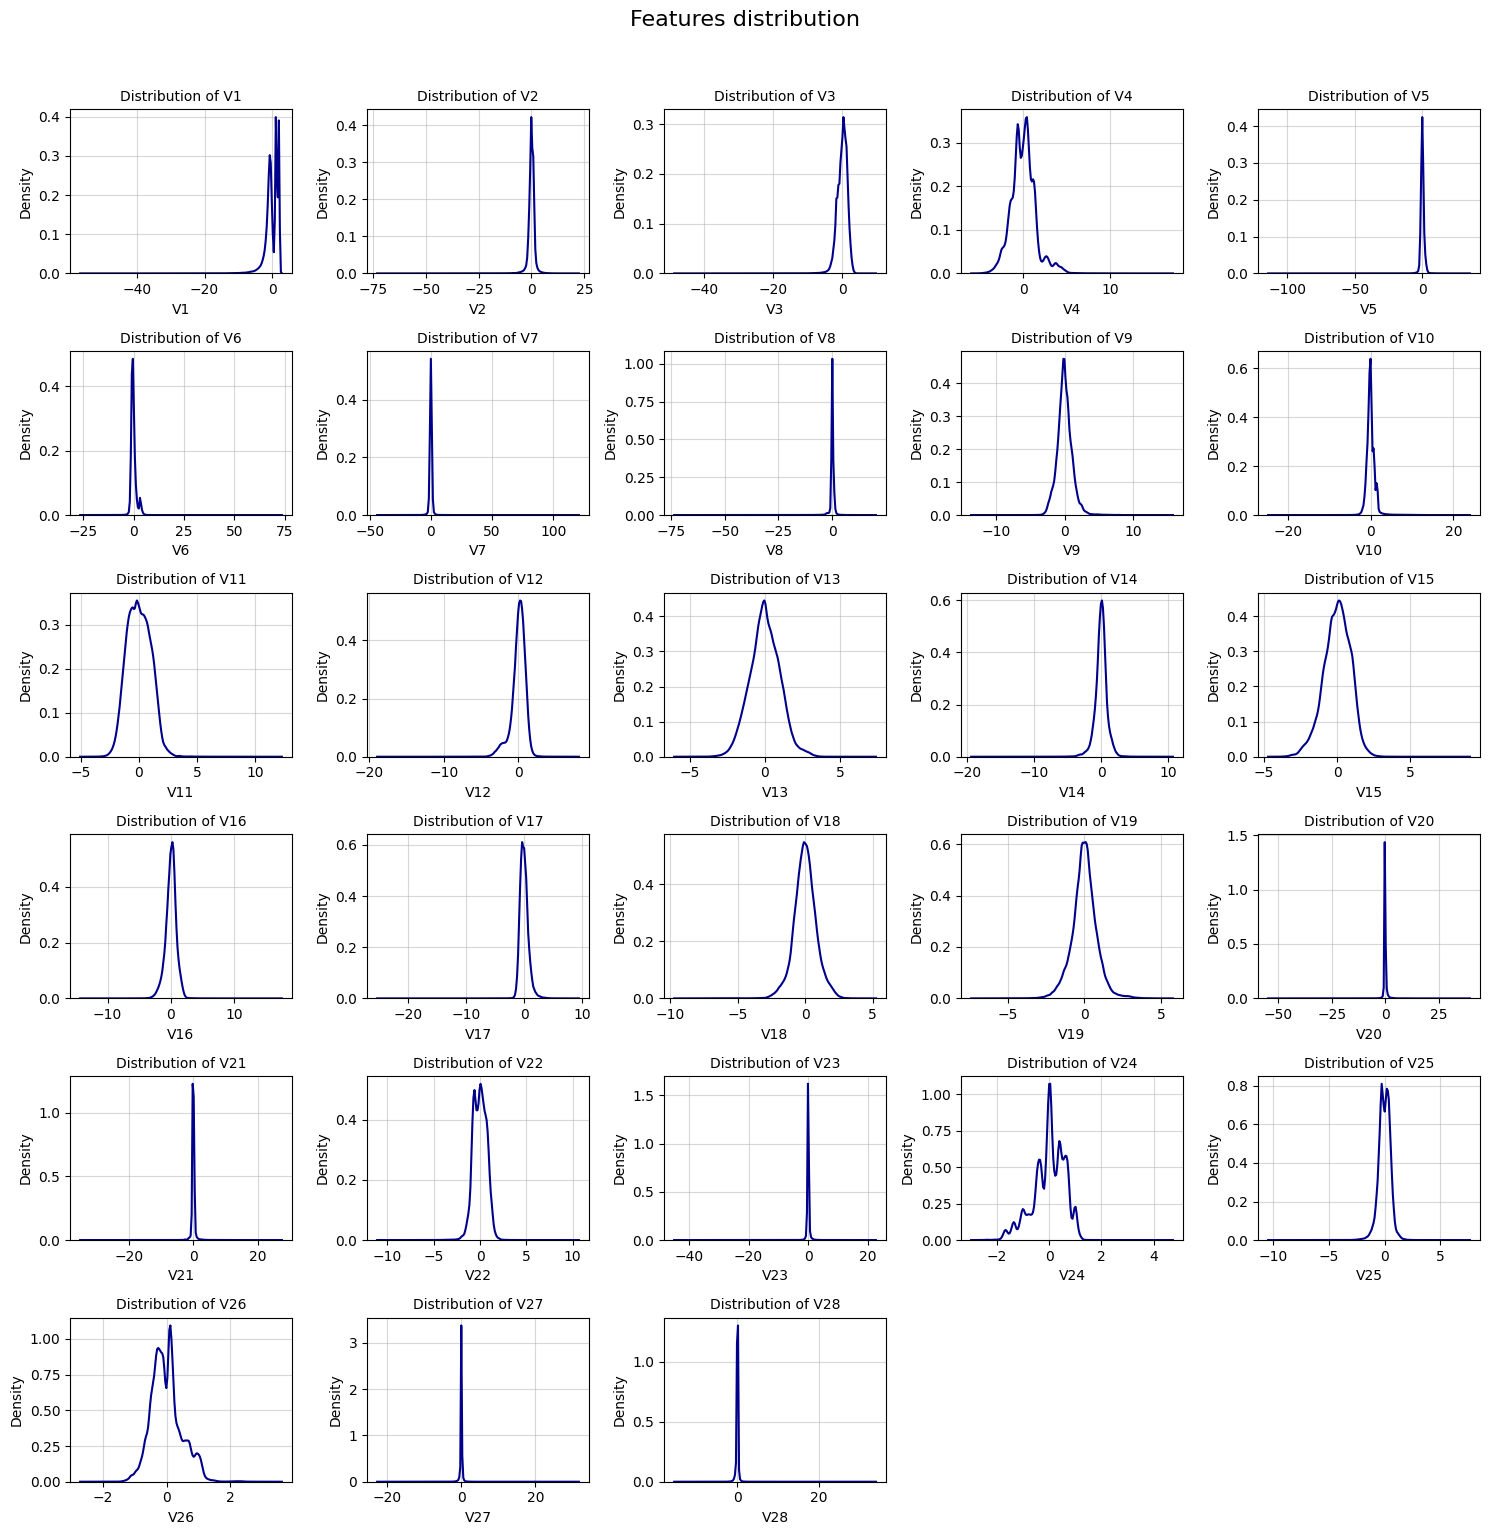

In [13]:
# Distribution of features
features = df.drop(['Time', 'Amount', 'Class'], axis=1).columns
plt.figure(figsize=(15, 15))

for i, feature in enumerate(features, 1):
    plt.subplot(6, 5, i)
    sns.kdeplot(df[feature], color='darkblue')
    plt.grid(True, alpha=0.5)
    plt.title(f'Distribution of {feature}', fontsize=10)

plt.suptitle('Features distribution', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

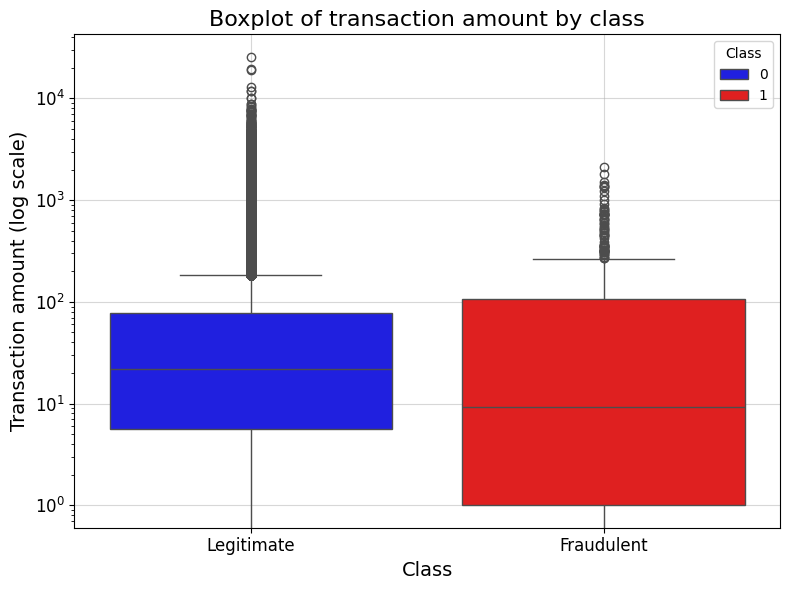

In [14]:
# Distribution of the 'Amount' feature
plt.figure(figsize=(8, 6))

# Create the boxplot with distinct colors for each class
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette=['blue', 'red'])

# Add labels and title
plt.title('Boxplot of transaction amount by class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Transaction amount (log scale)', fontsize=14)
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize=12)
plt.yticks(fontsize=12)

plt.yscale('log') # Use a log scale for the y-axis
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

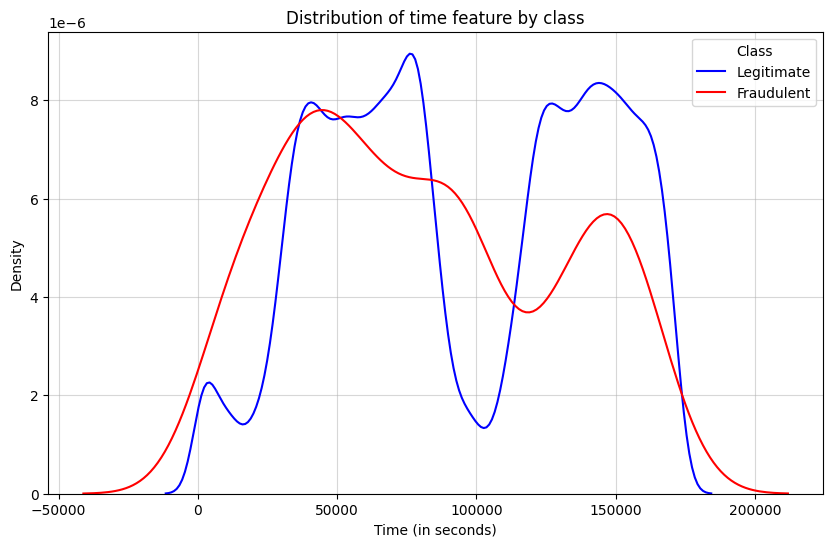

In [15]:
# Density plots for the 'Time' feature by class
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Class'] == 0]['Time'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Time'], color='red', label='Fraudulent')

# Add labels and title
plt.xlabel('Time (in seconds)')
plt.ylabel('Density')
plt.title('Distribution of time feature by class')
plt.legend(title='Class')
plt.grid(True, alpha=0.5)

plt.show()

In [33]:
(df['Time'] < 0).value_counts()

Time
False    284807
Name: count, dtype: int64

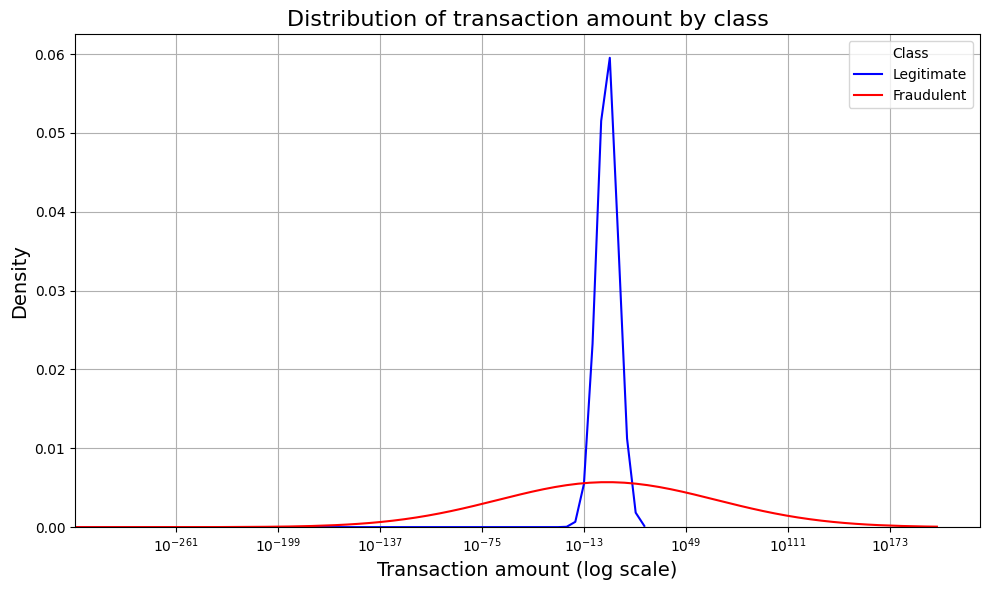

In [16]:
plt.figure(figsize=(10, 6))

plt.xscale('log') # Use a log scale for the y-axis
# Use density plots instead of histograms
sns.kdeplot(df[df['Class'] == 0]['Amount'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Amount'], color='red', label='Fraudulent')

# Add a grid
plt.grid(True)

# Add labels and title
plt.title('Distribution of transaction amount by class', fontsize=16)
plt.xlabel('Transaction amount (log scale)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class')

plt.tight_layout()
plt.show()

In [17]:
from imblearn.over_sampling import SMOTE

def handle_imbalanced_data(dataset: pd.DataFrame, method: str='over_sampling'):
    """
    Handle imbalanced data in a dataset.

    Parameters:
    dataset (DataFrame): The input dataset which is imbalanced.
    method (str): The method to handle imbalanced data. It can be 'over_sampling', 'under_sampling', 'smote'. Default is 'over_sampling'.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Get the counts of each class
    count_class_0, count_class_1 = dataset.Class.value_counts()

    # Divide the dataset by class
    df_class_0 = dataset[dataset['Class'] == 0]
    df_class_1 = dataset[dataset['Class'] == 1]

    # Oversampling: Oversample 1-class and concat the DataFrames of both classes
    if method == 'over_sampling':
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        return pd.concat([df_class_0, df_class_1_over], axis=0)

    # Undersampling: Undersample 0-class and concat the DataFrames of both classes
    elif method == 'under_sampling':
        df_class_0_under = df_class_0.sample(count_class_1)
        return pd.concat([df_class_0_under, df_class_1], axis=0)

    # SMOTE: Use SMOTE to oversample the minority class
    elif method == 'smote':
        smote = SMOTE(sampling_strategy='minority')
        X_sm, y_sm = smote.fit_resample(dataset.drop('Class', axis=1), dataset['Class'])
        return pd.concat([X_sm, y_sm], axis=1)

    # Method 4, Use of Ensemble with undersampling: Not implemented
    # ...
    else:
        raise ValueError("Invalid method. It should be 'over_sampling', 'under_sampling', 'smote' ... ")

In [18]:
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method)
    print(f'Balanced data using {method} method: \n{balanced_data.Class.value_counts()}\n')

Balanced data using over_sampling method: 
Class
0    284315
1    284315
Name: count, dtype: int64

Balanced data using under_sampling method: 
Class
0    492
1    492
Name: count, dtype: int64

Balanced data using smote method: 
Class
0    284315
1    284315
Name: count, dtype: int64



In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Models to search and their parameters
models_params = [
    {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]}
    },
    {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]}
    },
    {
        'model': SVC(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    }
]

# Perform grid search for each model
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method)
    X = balanced_data.drop('Class', axis=1)
    y = balanced_data['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # for mp in models_params:
    #     grid_search = GridSearchCV(estimator=mp['model'], param_grid=mp['params'])
    #     grid_search.fit(X_train, y_train)
    #     print(f'Best parameters for {method} method with: {grid_search.best_params_}')